# Модель лесного пожара

Лес состоит и пустой сетки $N \times N$. На протяжении каждого периода случайным образом
выбирается участок на сетке. Если участок пустой, то с вероятностью $p$ на нем вырастает
дерево, а с веростностью $1 - p$ не происходит ничего.

Если на участке растет дерево, то оно
с вероятностью $1 - p$ загорается и огонь распроcтраняется на все примыкающие участки с
деревьями.


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from scipy.stats import shapiro

In [26]:
class ForestField:
    def __init__(self, n=5, p = 0.6) -> None:
        self.n = n
        self.field = np.zeros((self.n, self.n), dtype=np.int32)
        self.p = p
        self.treesPreFire = []
        self.treesPostFire = []
        self.dirt = 0
        self.tree = 1
        self.fire = -1
         
    def step(self, burnAll = False):
        cell = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        rand_val = np.random.rand()
        self.draw(img)
        #forest growth
        if self.field[cell[0], cell[1]] == self.dirt and rand_val < self.p:
                self.field[cell[0], cell[1]] = 1
        self.treesPreFire.append(self.countTrees())
        #lightning strike
        if self.field[cell[0], cell[1]] == self.tree and rand_val >= self.p:
            self.field[cell[0], cell[1]] = -1
        self.draw(img)
        #fire spread
        self.fireSpread(burnAll)
        self.draw(img)
        #fire extinguish
        self.field[self.field == self.fire] = self.dirt
        self.draw(img)
        self.treesPostFire.append(self.countTrees())
        self.draw(img)
        
    def fireSpread(self, burnAll = False):
        dx = [-1, 0, 1, 0, -1, -1, 1, 1]
        dy = [0, 1, 0, -1, -1, 1, 1, -1]
        old_field = None
        while old_field is None or (old_field != self.field).any():
            old_field = self.field.copy()
            fire_indices = np.where(self.field == self.fire)
            fire_indices = list(zip(fire_indices[0], fire_indices[1]))
            for idx in fire_indices:
                i, j = idx
                for k in range(len(dx)):
                    if not ( 0 <= i + dx[k] < self.n and 0 <= j + dy[k] < self.n):
                        continue
                    if self.field[i + dx[k]][j + dy[k]] == self.dirt:
                        continue
                    self.field[i + dx[k]][j + dy[k]] = self.fire
            if not burnAll:
                return
        
    def countTrees(self):
        return np.sum(self.field[self.field == self.tree])

Посмотрим на численность леса в течение продолжительного времени и исследуем распределение леса по его размеру

In [27]:
n = 10
p = 0.7
forest = ForestField(n=n, p=p)
time_steps = 10000

In [28]:
for _ in range(time_steps):
    forest.step(burnAll=True)

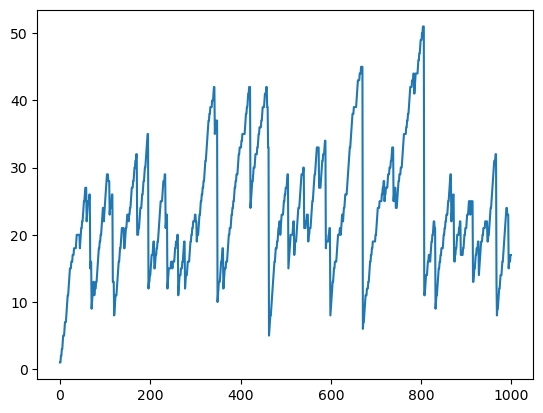

In [29]:
plt.plot(np.arange(len(forest.treesPreFire)), forest.treesPreFire)

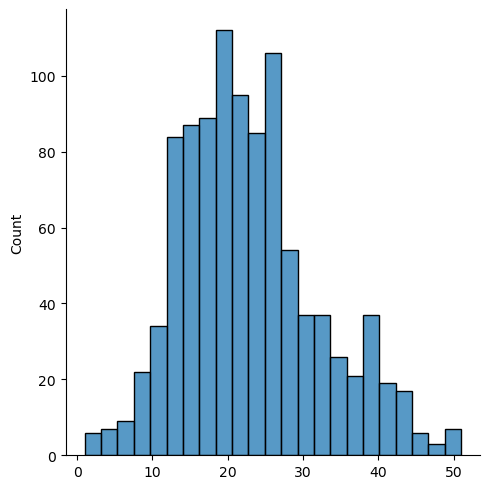

In [30]:
sns.displot(forest.treesPostFire)

In [31]:
stat, p = shapiro(forest.treesPostFire)
alpha = 0.05
if p > alpha:
    print('Распределение соответствует нормальному')
else:
    print('Распределение не похоже на нормальное')

Распределение не похоже на нормальное


Согласно статистическому тесту полученное распределение не является нормальным. Однако, по его виду можно оценить теоретическое значение среднего размера леса.

In [32]:
mean_size = np.mean(forest.treesPostFire)
print('Средний размер леса: ', np.round(mean_size))

Средний размер леса:  23.0


Проверим зависимость среднего размера леса от вероятности вырастания дерева $p$. Для этого проведём серию экспериментов с различными значениями вероятности и построим экспериментальную зависимость

In [39]:
p_vals = np.arange(0.01, 1, 0.09)
mean_vals = []
for p in p_vals:
    exp_forest = ForestField(n,p)
    for _ in range(time_steps):
        exp_forest.step(burnAll=True)
    mean_vals.append(np.mean(exp_forest.treesPostFire))

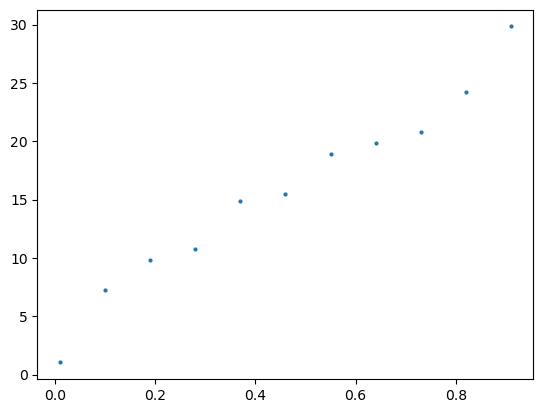

In [40]:
plt.scatter(p_vals, mean_vals, s=4)